# Train a Human Activity Recognition Model for a Microcontroller

(Optional) Install the Nvidia CUDA Toolkit and cuDNN to utilize GPU acceleration for TensorFlow

For Ubuntu 20.04 this is done via
```bash
# Install the kernel headers and development packages for the current kernel 
sudo apt-get install linux-headers-$(uname -r)

# set version vars
OS=ubuntu2004
cuda_version=11.5.1
cudnn_version=8.3.1.*

# Enable the repository. The following commands enable the repository containing information about the appropriate cuDNN libraries online for Ubuntu 18.04 and 20.04.
wget https://developer.download.nvidia.com/compute/cuda/repos/${OS}/x86_64/cuda-${OS}.pin 
sudo mv cuda-${OS}.pin /etc/apt/preferences.d/cuda-repository-pin-600
sudo apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/${OS}/x86_64/7fa2af80.pub
sudo add-apt-repository "deb https://developer.download.nvidia.com/compute/cuda/repos/${OS}/x86_64/ /"
sudo apt-get update

# Download and Install the cuda toolkit
sudo apt-get -y install cuda

# Install the cuDNN library:
sudo apt-get install libcudnn8=${cudnn_version}-1+cuda${cuda_version}
sudo apt-get install libcudnn8-dev=${cudnn_version}-1+cuda${cuda_version}
```


In [1]:
# Clone the TensorFlow Lite and FlatBuffers repositories from GitHub
#!git clone --depth 1 -q https://github.com/tensorflow/tflite-micro.git ../tflite-micro
#!git clone --depth 1 -q https://github.com/google/flatbuffers.git ../sketch/flatbuffers

In [2]:
import datetime
from multiprocessing import Pool
import os

from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf

from load_data import DataLoader
from prepare_data import write_instance

In [3]:
# Set TensorFlow log level to Warn (to no avail) and list GPUs available
tf.get_logger().setLevel('WARN')
tf.config.list_physical_devices("GPU")

2021-12-06 23:45:07.759872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-06 23:45:07.795693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-06 23:45:07.795910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Download, prepare, and load the dataset

In [4]:
!wget https://github.com/gmbhat/human-activity-recognition/raw/master/datasets/data_with_windows/motion_data_22_users_with_window.csv
!mkdir -p data/raw && mv motion_data_22_users_with_window.csv data/raw

--2021-12-06 23:45:07--  https://github.com/gmbhat/human-activity-recognition/raw/master/datasets/data_with_windows/motion_data_22_users_with_window.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/gmbhat/human-activity-recognition/master/datasets/data_with_windows/motion_data_22_users_with_window.csv [following]
--2021-12-06 23:45:08--  https://media.githubusercontent.com/media/gmbhat/human-activity-recognition/master/datasets/data_with_windows/motion_data_22_users_with_window.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 377147198 (360M) [text/plain]
Saving to: ‘motion

In [5]:
dataset_path = "./data/raw/motion_data_22_users_with_window.csv"

# scan headers in first row to add the missing one for the label  
with open(dataset_path, "r") as f:
    header = f.readline().strip().replace(" ", "_").split(",") + ["Activity"]

df = pd.read_csv(dataset_path, index_col=False, header=0, names=header)

print(f"Data Shape: {df.shape}\n")
print(f"Data Types:\n{df.dtypes}\n")
df.sample(5)


Data Shape: (2458250, 12)

Data Types:
Time_(s)         float64
User               int64
Scenerio           int64
Trial              int64
Window_Number      int64
Ax               float64
Ay               float64
Az               float64
GyroX            float64
GyroY            float64
GyroZ            float64
Activity          object
dtype: object



,Time_(s),User,Scenerio,Trial,Window_Number,Ax,Ay,Az,GyroX,GyroY,GyroZ,Activity
616926,30.328,2,3,3,18,0.047852,0.984375,-0.194336,-1.557252,-0.603053,-0.015267,stand
892900,61.608,4,1,5,36,-0.082520,0.969238,-0.093262,-112.496183,-210.435115,74.862595,transition
965275,78.028,4,1,8,40,0.030762,0.995850,0.195312,-1.549618,-0.175573,-0.267176,sit
412544,53.820,2,2,1,20,0.078857,0.999268,-0.081299,-1.374046,-0.190840,0.091603,sit
845279,40.012,3,5,1,24,-0.425049,0.796875,0.074951,9.129771,32.893130,-11.320611,walk


In [6]:
# Simplify our problem a bit, by combining sit/stand and transition/undefined
df.Activity = df.Activity.replace({
    "sit": "sit/stand",
    "stand": "sit/stand",
    "transition": "transition/undefined",
    "undefined": "transition/undefined",
})

## Prepare the dataset by instance (motion segment)

In [7]:
instance_cols = ["Activity", "User", "Scenerio", "Trial", "Window_Number"]

# Split the data into train, valid, and test by instance
instance_indices = df.groupby(instance_cols, as_index=True).count().index
train, valid = train_test_split(instance_indices, test_size=0.3)
valid, test = train_test_split(valid, test_size=0.5)
sets = {"train": train, "valid": valid, "test": test}

# Function to map to each split of the data
def write_set_instances(df, set_name, set_idx):

    set_path = "./data/processed/instance"
    os.makedirs(set_path, exist_ok=True)
    
    # Write the motion data for each activty, user, and motion segment (instance)
    instance_cols = ["Activity", "User", "Scenerio", "Trial", "Window_Number"]
    set_instances = df.set_index(instance_cols).loc[set_idx].reset_index()
    
    with open(os.path.join(set_path, set_name), "w") as f:
        for idx, instance in set_instances.groupby(instance_cols):
            write_instance(f, idx, instance)

# Create train, valid, and test set files in parallel
pool = Pool(3)
pool.starmap(write_set_instances, [(df, k, v)  for k, v in sets.items()])
pool.close()

In [8]:
# Prepare the data for 
seq_length = 256
num_features = 3
datafiles = [f"./data/processed/instance/{f}" for f in ["train", "valid", "test"]]
d = DataLoader(*datafiles, seq_length, num_features)

train_data_length:3472
valid_data_length:744
test_data_length:744


2021-12-06 23:46:33.642776: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-06 23:46:33.644154: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-06 23:46:33.644396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-06 23:46:33.644553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## Build the CNN model

In [9]:
%%capture
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        12, (5, 5),
        padding="same",
        activation="relu",
        input_shape=(seq_length, num_features, 1)
    ),
    tf.keras.layers.MaxPool2D((3, 3)),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Conv2D(16, (4, 1), padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D((3, 1), padding="same"),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(7, activation="softmax")
])

# Export CNN architecture to image for presentation
plot_model(model, to_file="../docs/model_plot.png", show_shapes=True, show_layer_names=True)

2021-12-06 23:46:34.863384: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-06 23:46:34.863409: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-06 23:46:34.863438: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2021-12-06 23:46:34.863665: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/lib64
2021-12-06 23:46:34.945647: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-06 23:46:34.945852: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


## Load TensorBoard

In [10]:
%%capture
%load_ext tensorboard
%tensorboard --logdir logs/scalars --host localhost --port 8088

## Begin training the CNN model

In [11]:
def reshape_function(data, label):
    reshaped_data = tf.reshape(data, [-1, num_features, 1])
    return reshaped_data, label

def calculate_model_size(model):
    #print(model.summary())
    var_sizes = [
        np.product(list(map(int, v.shape))) * v.dtype.size
        for v in model.trainable_variables
    ]
    print("Model size:", sum(var_sizes) / 1024, "KB")

calculate_model_size(model)

epochs = 15
batch_size = 64

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

train_data = d.train_data.map(reshape_function)
test_data = d.test_data.map(reshape_function)
valid_data = d.valid_data.map(reshape_function)
test_labels = np.zeros(d.test_len)
idx = 0
for data, label in test_data:
    test_labels[idx] = label.numpy()
    idx += 1

train_data = train_data.batch(batch_size).repeat()
valid_data = valid_data.batch(batch_size)
test_data = test_data.batch(batch_size)

model.fit(
    train_data,
    epochs=epochs,
    validation_data=valid_data,
    steps_per_epoch=1000,
    validation_steps=int((d.valid_len - 1) / batch_size + 1),
    callbacks=[tensorboard_callback]
)

Model size: 33.80859375 KB


2021-12-06 23:46:37.351413: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2021-12-06 23:46:38.305157: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8301


   1/1000 [..............................] - ETA: 20:58 - loss: 2.0712 - accuracy: 0.0938

2021-12-06 23:46:38.640205: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-12-06 23:46:38.823928: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-06 23:46:38.823953: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  34/1000 [>.............................] - ETA: 11s - loss: 2.0339 - accuracy: 0.2243

2021-12-06 23:46:39.016549: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-06 23:46:39.016920: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-12-06 23:46:39.055757: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 133 callback api events and 130 activity events. 
2021-12-06 23:46:39.060791: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-06 23:46:39.066574: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/scalars/20211206-234634/train/plugins/profile/2021_12_06_23_46_39

2021-12-06 23:46:39.070664: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/scalars/20211206-234634/train/plugins/profile/2021_12_06_23_46_39/desktop.trace.json.gz
2021-12-06 23:46:39.078064: I tensorflow/core/profiler/rpc/client/save_profile.

1000/1000 [==============================] - 5s 4ms/step - loss: 1.6813 - accuracy: 0.4621 - val_loss: 1.2741 - val_accuracy: 0.7110
Epoch 2/15
1000/1000 [==============================] - 3s 3ms/step - loss: 1.1945 - accuracy: 0.7001 - val_loss: 0.8082 - val_accuracy: 0.7708
Epoch 3/15
1000/1000 [==============================] - 3s 3ms/step - loss: 0.9221 - accuracy: 0.7262 - val_loss: 0.6383 - val_accuracy: 0.8011
Epoch 4/15
1000/1000 [==============================] - 3s 3ms/step - loss: 0.7558 - accuracy: 0.7607 - val_loss: 0.5809 - val_accuracy: 0.8206
Epoch 5/15
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6097 - accuracy: 0.8031 - val_loss: 0.4732 - val_accuracy: 0.8454
Epoch 6/15
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5327 - accuracy: 0.8225 - val_loss: 0.4213 - val_accuracy: 0.8602
Epoch 7/15
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4688 - accuracy: 0.8406 - val_loss: 0.3945 - val_accuracy: 0.8777
Epo

24/24 [==============================] - 0s 2ms/step - loss: 0.3562 - accuracy: 0.8797
Loss 0.35624146461486816, Accuracy 0.8797042965888977


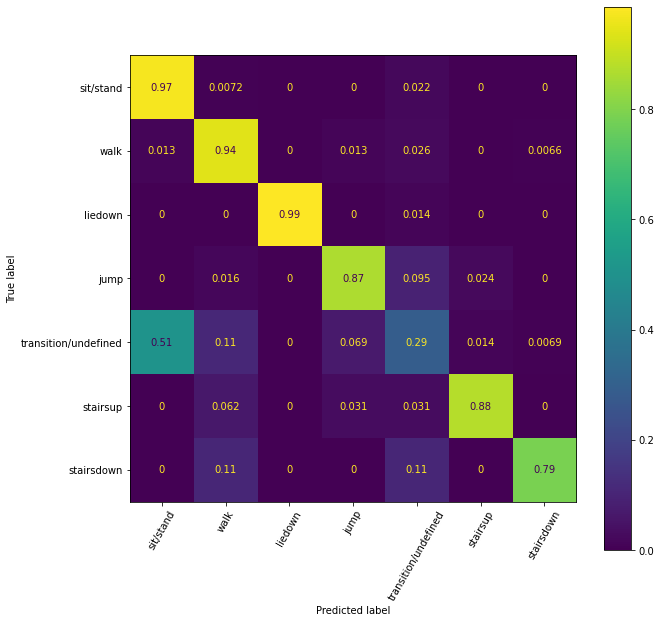

In [12]:
loss, acc = model.evaluate(test_data)
print("Loss {}, Accuracy {}".format(loss, acc))

pred = np.argmax(model.predict(test_data), axis=1)
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(
    test_labels,
    pred,
    normalize="true",
    display_labels={
        "sit/stand": 0,
        "walk": 1,
        "liedown": 2,
        "jump": 3,
        "transition/undefined": 4,
        "stairsup": 5,
        "stairsdown": 6,
        },
        xticks_rotation=60,
        ax=ax)

## Convert the model to TensorFlow Lite format

In [13]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("models/model.tflite", "wb").write(tflite_model)

# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model to disk
open("models/model_quantized.tflite", "wb").write(tflite_model)

basic_model_size = os.path.getsize("models/model.tflite")
print("Basic model is %d bytes" % basic_model_size)
quantized_model_size = os.path.getsize("models/model_quantized.tflite")
print("Quantized model is %d bytes" % quantized_model_size)
difference = basic_model_size - quantized_model_size
print("Difference is %d bytes" % difference)

2021-12-06 23:47:26.346954: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2021-12-06 23:47:26.883883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-06 23:47:26.884048: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2021-12-06 23:47:26.884152: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-12-06 23:47:26.884522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-06 23:47:26.884695: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had ne

Basic model is 37708 bytes
Quantized model is 15664 bytes
Difference is 22044 bytes


2021-12-06 23:47:27.748320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-06 23:47:27.748504: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2021-12-06 23:47:27.748583: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-12-06 23:47:27.748850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-06 23:47:27.749032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-06 23:47:27.749195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

## Create a C source file

We need to convert the model to a C++ source file so it can be used with TensorFlow Lite for Microcontrollers.

First install xxd if it isn't already:
```bash
apt-get -qq install xxd
```

In [14]:
# Save the file as a C source file
!xxd -i model.tflite > models/model.cc
# Print the source file
!cat models/model.cc

unsigned char model_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x1c, 0x00, 0x14, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x00, 0x00, 0x2c, 0x00, 0x00, 0x00, 0xd8, 0x00, 0x00, 0x00,
  0x2c, 0x00, 0x00, 0x00, 0x80, 0x00, 0x00, 0x00, 0x78, 0x00, 0x00, 0x00,
  0x05, 0x00, 0x00, 0x00, 0x28, 0x07, 0x00, 0x00, 0x44, 0x06, 0x00, 0x00,
  0xbc, 0x03, 0x00, 0x00, 0xf8, 0x02, 0x00, 0x00, 0xac, 0x01, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0xd0, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x2c, 0x93, 0x00, 0x00, 0x28, 0x93, 0x00, 0x00, 0x4c, 0x92, 0x00, 0x00,
  0xa8, 0x91, 0x00, 0x00, 0x00, 0x91, 0x00, 0x00, 0x58, 0x90, 0x00, 0x00,
  0xc0, 0x8f, 0x00, 0x00, 0x70, 0x1b, 0x00, 0x00, 0x1c, 0x19, 0x00, 0x00,
  0x10, 0x14, 0x00, 0x00, 0xb4, 0x07, 0x00, 0x00, 0x00, 0x93, 0x00, 0x00,
  0xfc, 0x92, 0x00, 0x00, 0xf8, 0x92, 0x00, 0x00, 0xf4, 0x92, 0x00, 0x00,
  0xf